In [1]:
# %load main.py
import argparse
import time
import os
import os.path

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

import PIL
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
from utility.utility import postp, GramMatrix, GramMSELoss, load_images, save_images, make_folders
from utility.vgg_network import VGG

In [2]:
# style weights
sw1=1
sw2=1
sw3=1
sw4=1
sw5=1
# Content weights
cw1=0
cw2=0
cw3=0
cw4=1e5
cw5=0
#############################################################################
# Get image paths and names
# Style 1
style_dir1  = os.path.dirname('../input/font_contents/serif/A/Milonga-Regular.png')
style_name1 = os.path.basename('../input/font_contents/serif/A/Milonga-Regular.png')
# Style 2
style_dir2  = os.path.dirname('../input/font_contents/serif_rmv/A/Milonga-Regular.png')
style_name2 = os.path.basename('../input/font_contents/serif_rmv/A/Milonga-Regular.png')
# Content
content_dir  = os.path.dirname('../input/font_contents/AlegreyaSans-Light/A.png')
content_name = os.path.basename('../input/font_contents/AlegreyaSans-Light/A.png')

# Cuda device
if torch.cuda.is_available:
    device = 'cuda:0'
else:
    device = 'cpu'
print("Using device: ", device)

# Parameters
alpha = 1
beta = 1
image_size = 256
content_invert = 1
style_invert = 1
result_invert = content_invert

# Get output path
output_path = '../output_style_difference/'
try:
    os.mkdir(output_path)
except:
    pass
output_path = output_path + content_name[:-4] + '_' + style_name1[:-4] + '_' + style_name2[:-4] + '/'

Using device:  cuda:0


In [4]:
# Get network
vgg = VGG()
vgg.load_state_dict(torch.load('../Models/vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

# Load images
content_image = load_images(os.path.join(content_dir, content_name), image_size, device, content_invert)
style_image1  = load_images(os.path.join(style_dir1,style_name1), image_size, device, style_invert)
style_image2  = load_images(os.path.join(style_dir2,style_name2), image_size, device, style_invert)

# Random input
# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data).to(device), requires_grad=True).to(device)
# Content input
opt_img = Variable(content_image.data.clone(), requires_grad=True)

In [5]:
# Define layers, loss functions, weights and compute optimization targets
# Style layers
style_layers = ['r11','r21','r31','r41','r51'] 
style_weights = [sw1*1e3/(64**2), sw2*1e3/(128**2), sw3*1e3/(256**2), sw4*1e3/(512**2), sw5*1e3/(512**2)]
# Content layers
content_layers = ['r42']
content_weights = [cw4]
# content_layers = ['r12','r22','r32','r42','r52']
# content_weights = [args.cw1, args.cw2, args.cw3, args.cw4, args.cw5]

loss_layers = style_layers + content_layers
loss_functions = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_functions = [loss_fn.to(device) for loss_fn in loss_functions]
weights = style_weights + content_weights

In [17]:
# Compute optimization targets
### Gram matrix targets

# Feature maps from style layers of the style image
style1_fms_style = [A.detach() for A in vgg(style_image1, style_layers)]
style2_fms_style = [A.detach() for A in vgg(style_image2, style_layers)]
# Difference of feature maps
style_fms_style  = [style1_fms_style[i] - style2_fms_style[i] for i in range(len(style1_fms_style))]
# Gram matrix of difference feature maps
gramm_style = [GramMatrix()(A) for A in style_fms_style]
# Feature maps from style layers of the content image
content_fms_style = [A.detach() for A in vgg(content_image, style_layers)]


# Feature responces of 1st style
fm_style1 = [A.detach() for A in vgg(style_image1, content_layers)]
# Feature responces of 2nd style
fm_style2 = [A.detach() for A in vgg(style_image2, content_layers)]
style_content = []
for i in range(len(fm_style1)):
    style_content.append((fm_style2[i] - fm_style1[i]))
### Content targets
# Feature responces of content
fm_content = [A.detach() for A in vgg(content_image, content_layers)]
# Gram matrices of content
gramm_content  = [GramMatrix()(A).detach() for A in vgg(content_image, style_layers)]

# Run style transfer
make_folders(output_path)

In [10]:
max_iter = 1200
show_iter = 100
optimizer = optim.LBFGS([opt_img])
n_iter=[0]
loss_list = []
c_loss = []
s_loss = []

In [20]:
optimizer.zero_grad()
out = vgg(opt_img, loss_layers)
content_layer_losses = []
style_layer_losses  = []

opt_fms_style = []
opt_fms_content = []
# Divide between style feature maps and content feature maps
for i, A in enumerate(out):
    if i < len(gramm_style):
        opt_fms_style.append(A)
    else:
        opt_fms_content.append(A)

In [21]:
# Difference between feature maps on style layers
diff_fms_style = [content_fms_style[i] - opt_fms_style[i] for i in range(len(content_fms_style))]
gramm_diff = [GramMatrix()(A) for A in diff_fms_style]

In [ ]:
a = gramm_diff[0]
b = gramm_style[0]
nn.MSELoss(a,b)

In [22]:
# Difference between gram matrix of feature map differences
style_layer_losses = [style_weights[i]*(nn.MSELoss()(gramm_diff[i], gramm_style[i])) for i in range(len(gramm_diff))]

# Difference between feature responces of content and optimized
results_content = []
for i in range(len(fm_content)):
    results_content.append((fm_content[i] - opt_fms_content[i]))
# Content loss between style_content and results
for i in range(len(fm_content)):
    content_layer_losses.append(content_weights[i]*(nn.MSELoss()(results_content[i], style_content[i])))

In [15]:
for i in range(len(results_style)):
    print(results_style[i].shape)

torch.Size([1, 64, 64])
torch.Size([1, 128, 128])
torch.Size([1, 256, 256])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


In [12]:
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        content_layer_losses = []
        style_layer_losses  = []
        
        opt_style = []
        opt_content = []
        # Divide between gram matrix and feature responce
        for i, A in enumerate(out):
            if i < len(style_targets):
                opt_style.append(GramMatrix()(A))
            else:
                opt_content.append(A)

        # Difference between the gram matrices of content and optimized
        results_style = []
        for i in range(len(gramm_content)):
            results_style.append((gramm_content[i] - opt_style[i]))
        # Difference between feature responces of content and optimized
        results_content = []
        for i in range(len(fm_content)):
            results_content.append((fm_content[i] - opt_content[i]))
        
        # Style loss between style_target and results
        for i in range(len(gramm_content)):
            style_layer_losses.append(style_weights[i]*(nn.MSELoss()(results_style[i], style_targets[i])))
        # Content loss between style_content and results
        for i in range(len(fm_content)):
            content_layer_losses.append(content_weights[i]*(nn.MSELoss()(results_content[i], style_content[i])))
        
        layer_losses = content_layer_losses + style_layer_losses
#         layer_losses = content_layer_losses

        content_loss = sum(content_layer_losses)
        style_loss   = sum(style_layer_losses)

        loss = sum(layer_losses)
        loss.backward()
        c_loss.append(content_loss)
        s_loss.append(style_loss)
        loss_list.append(loss)

        #print loss
        if n_iter[0]%show_iter == 0:
            print('Iteration: {} \nContent loss: {} \nStyle loss  : {} \nTotal loss  : {}'
            .format(n_iter[0], content_loss.item(), style_loss.item(), loss.item()))

            # Save loss graph
            plt.plot(loss_list, label='Total loss')
            plt.plot(c_loss, label='Content loss')
            plt.plot(s_loss, label='Style loss')
            plt.legend()
            plt.savefig(output_path + 'loss_graph.jpg')
            plt.close()
            # Save optimized image
            out_img = postp(opt_img.data[0].cpu().squeeze(), image_size, result_invert)
            #out_img = PIL.ImageOps.invert(out_img)
            out_img.save(output_path + 'outputs/{}.bmp'.format(n_iter[0]))
        n_iter[0] += 1
        return loss
      
    optimizer.step(closure)

Iteration: 0 
Content loss: 2488124928.0 
Style loss  : 7610064.5 
Total loss  : 2495734784.0
Iteration: 100 
Content loss: 2375035136.0 
Style loss  : 6546340.5 
Total loss  : 2381581312.0
Iteration: 200 
Content loss: 2259005696.0 
Style loss  : 5798837.5 
Total loss  : 2264804608.0
Iteration: 300 
Content loss: 2201672960.0 
Style loss  : 5446743.0 
Total loss  : 2207119872.0
Iteration: 400 
Content loss: 2169997056.0 
Style loss  : 5311504.0 
Total loss  : 2175308544.0
Iteration: 500 
Content loss: 2153166336.0 
Style loss  : 5214926.5 
Total loss  : 2158381056.0
Iteration: 600 
Content loss: 2143861760.0 
Style loss  : 5158906.0 
Total loss  : 2149020672.0
Iteration: 700 
Content loss: 2136584320.0 
Style loss  : 5123154.0 
Total loss  : 2141707520.0
Iteration: 800 
Content loss: 2130641152.0 
Style loss  : 5107080.5 
Total loss  : 2135748224.0
Iteration: 900 
Content loss: 2125251712.0 
Style loss  : 5076470.5 
Total loss  : 2130328192.0
Iteration: 1000 
Content loss: 2121030528.

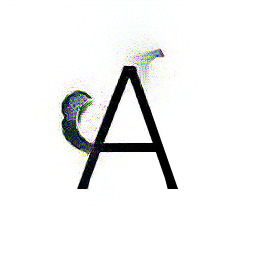

In [13]:
postp(opt_img.data[0].cpu().squeeze(), image_size, result_invert)

In [14]:
# Save sum images
save_images(content_image.data[0].cpu().squeeze(), opt_img.data[0].cpu().squeeze(), style_image1.data[0].cpu().squeeze(), style_image2.data[0].cpu().squeeze(), image_size, output_path, n_iter, content_invert, style_invert, result_invert)